# OCR testing utility
This notebook will compare combinations OCR engines and filters against each other with a test set of images.

## Test set
Collection of memes from reddit was OCRed by Google Vision API.

# Result
For each image, we calculate
- Time to OCR
- Accuracy of OCR

# Calculating accuracy
Since the results will be used in search engine and they resemble english words most of the times, I just calculate how many words are the same in both results.

In [1]:
import easyocr
import pytesseract
import cv2
import json
import os
import time
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
from typing import List, Dict, Any, Literal
from sys import path

path.append("../src")

from testerUtil import TestSettings, SingleTestResult, TestCase, TesterUtil, MultiTestResult
import reader
import filter
from dataset import Dataset

# Loads image path and its corresponding text
def loadMeme(memeId: str) -> tuple:
    imageFile = None
    for ext in ['jpg', 'jpeg', 'png']:
        if os.path.isfile(f'./memes/{memeId}.{ext}'):
            imageFile = f'./memes/{memeId}.{ext}'
            break

    if imageFile is None:
        raise Exception(f'Could not find image file for meme {memeId}')

    # load text file .txt
    with open(f'./memes/{memeId}.txt', 'r') as f:
        text = f.read().splitlines()

    return imageFile, text    

def loadDataset() -> list:
    memeIds = set([memeId.split('.')[0] for memeId in os.listdir('./memes') if memeId.endswith('.txt')])

    return [loadMeme(memeId) for memeId in memeIds]

def visualizeResults(results: List[MultiTestResult]):
    # point in space for each test
    # x = averageTime
    # y = averageSuccess

    plt.figure(figsize=(20,20))

    plt.rcParams.update({'font.size': 24})

    plt.rcParams['lines.markersize'] = 20

    # plot each test
    for (i, result) in enumerate(results):
        x = result.averageTime
        y = result.averageSuccess

        plt.scatter(x, y, label=str(result)+f"\nt: {x:.2f}ms\ns: {y:.2f}")

    plt.rcParams.update({'font.size': 14})

    # show legend below the graph
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)

    # axis labels
    plt.xlabel('Average time (ms)')
    plt.ylabel('Average success')

    plt.show()

<Figure size 648x576 with 0 Axes>

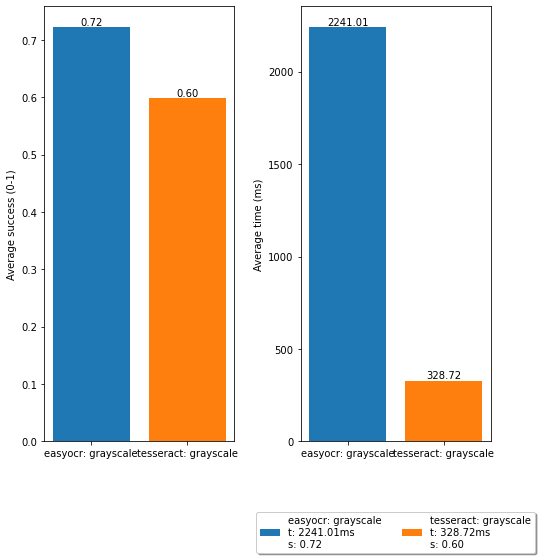

In [2]:
dataset = Dataset("../memes")
tester = TesterUtil("./cache.pyc", dataset)

filterList = [filter.GrayscaleFilter()]
readers = [reader.EasyOCRReader(), reader.TesseractReader()]

testSettings = [TestSettings(reader, [currFilter]) for currFilter in filterList for reader in readers]

results = [tester.test(testSetting,100) for testSetting in testSettings]

plt.figure(figsize=(9, 8))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))

for (i, result) in enumerate(results):
    x = result.averageTime
    y = result.averageSuccess

    ax1.bar(str(result), y, label=str(result)+f"\nt: {x:.2f}ms\ns: {y:.2f}")
    ax2.bar(str(result), x, label=str(result)+f"\nt: {x:.2f}ms\ns: {y:.2f}")
    
    ax1.text(i, y, f"{y:.2f}", ha='center', va='bottom')
    ax2.text(i, x, f"{x:.2f}", ha='center', va='bottom')

plt.subplots_adjust(wspace=0.35)

ax1.set_ylabel('Average success (0-1)')
ax2.set_ylabel('Average time (ms)')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=5)


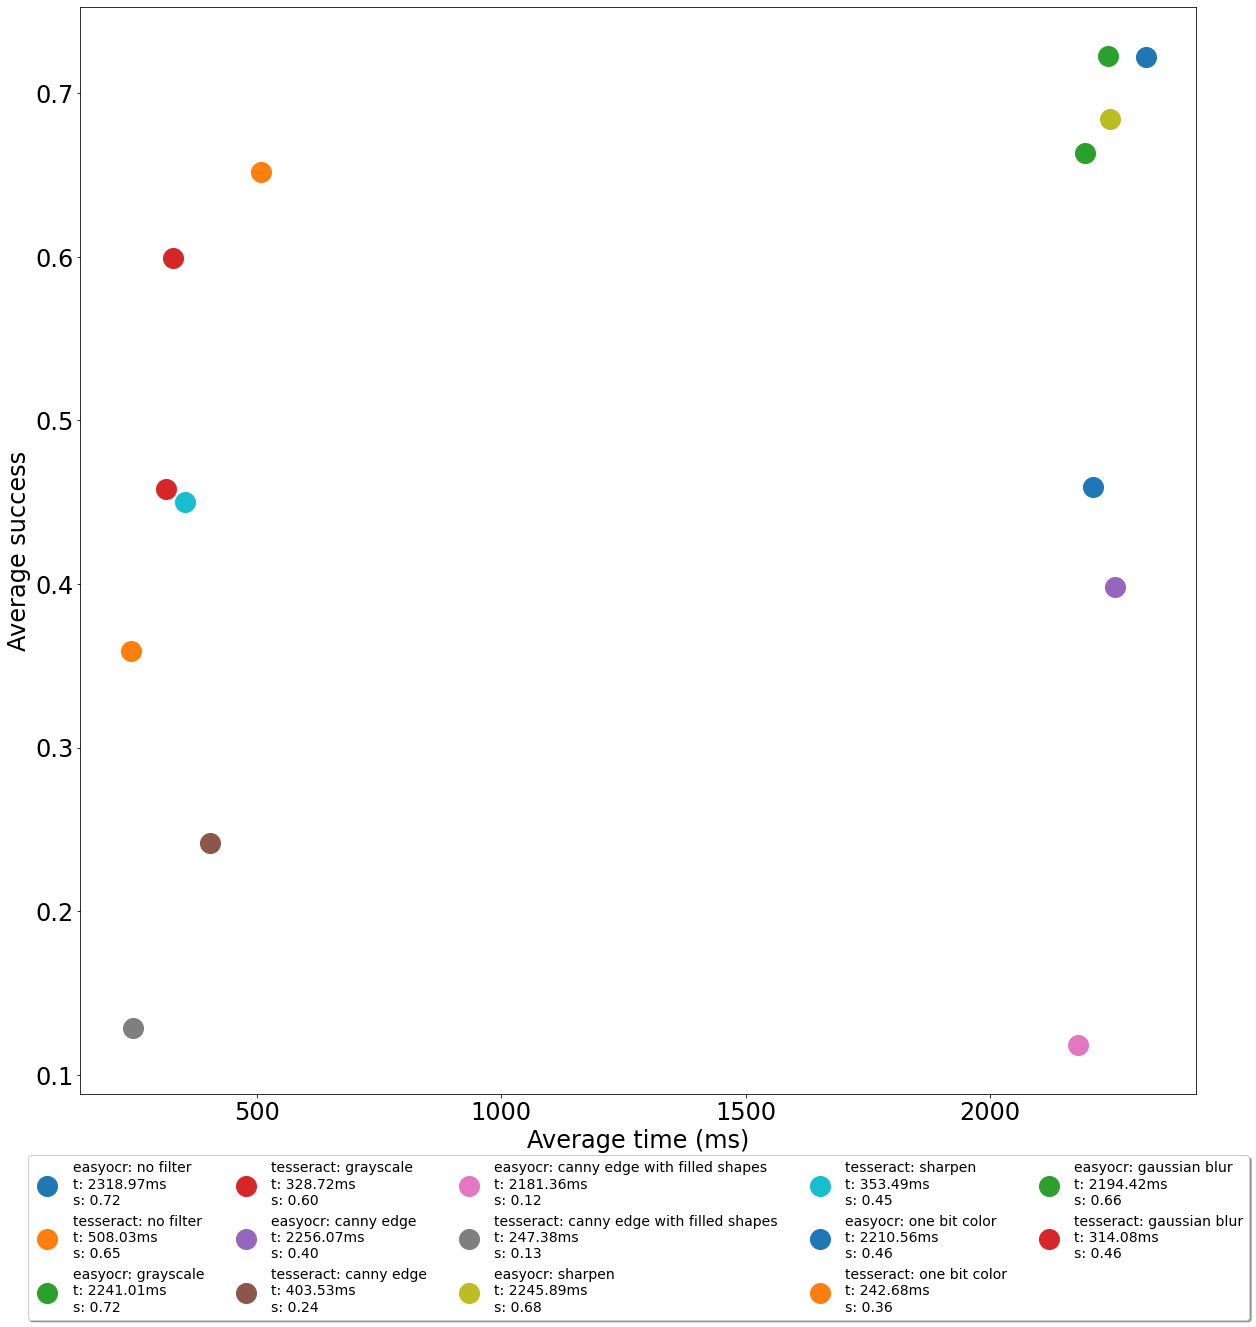

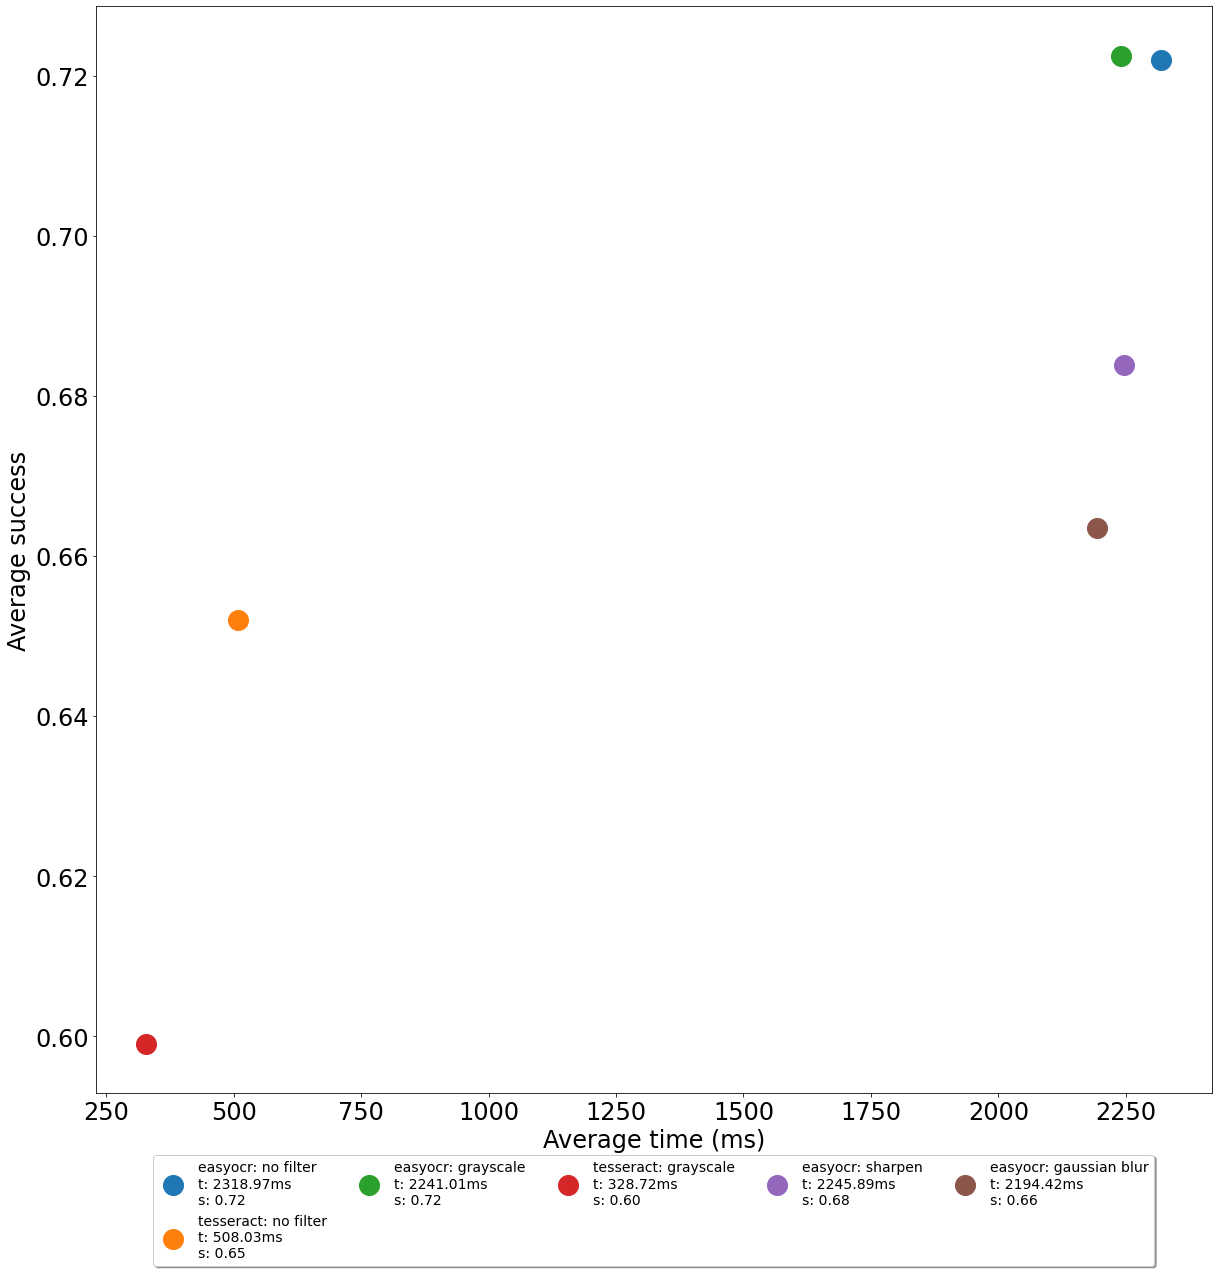

In [3]:
dataset = Dataset("../memes")
tester = TesterUtil("./cache.pyc", dataset)

filterList = [filter.NoFilter(),filter.GrayscaleFilter(), filter.CannyEdgeFilter(), filter.CannyEdgeWithFilledShapesFilter(), filter.SharpenFilter(), filter.OneBitColorFilter(), filter.GaussianBlurFilter()]
readers = [reader.EasyOCRReader(), reader.TesseractReader()]

testSettings = [TestSettings(reader, [currFilter]) for currFilter in filterList for reader in readers]

# import multiprocessing.dummy as mp 

# pool = mp.Pool(12)
# results = pool.map(tester.test, testSettings)
# pool.close()
# pool.join()

results = [tester.test(testSetting,100) for testSetting in testSettings]

visualizeResults(results)

# take only results over 0.5 success
results = [result for result in results if result.averageSuccess > 0.5]

visualizeResults(results)

Right now, there is significant difference between accuracy and time of both OCR engines. Tesseract is much faster (5-10times), but it's accuracy is about 50%. On the other hand, EasyOCR has over 70% accuracy.

It's hard not to mention the speed and accuracy of no filter vs grayscale filter. Grayscale is a little bit faster for both engines, but it's accuracy is a little bit lower. The real question now is, can we improve both of them using custom filters?

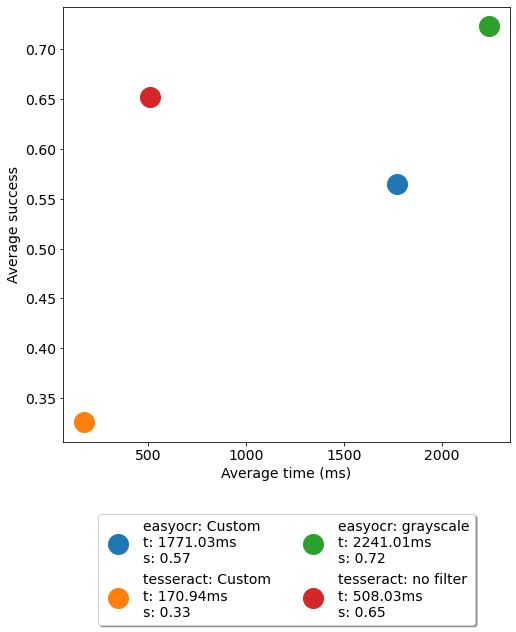

In [4]:
customFilterResults = [tester.test(TestSettings(reader, [filter.Custom()]), memeCount=100, ignoreCache=True) for reader in readers]

# find the best result for EasyOcr and tesseract
bestEasyOcrResult = max([result for result in results if str(result.testSettings.reader) == str(reader.EasyOCRReader())], key=lambda result: result.averageSuccess)
bestTesseractResult = max([result for result in results if str(result.testSettings.reader) == str(reader.TesseractReader())], key=lambda result: result.averageSuccess)

plt.figure(figsize=(8, 8))

newResults = customFilterResults + [bestEasyOcrResult, bestTesseractResult]


# plot each test
for (i, result) in enumerate(newResults):
    x = result.averageTime
    y = result.averageSuccess

    plt.scatter(x, y, label=str(result)+f"\nt: {x:.2f}ms\ns: {y:.2f}")

# show legend below the graph
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

plt.rcParams.update({'font.size': 20})

plt.xlabel('Average time (ms)')
plt.ylabel('Average success')

plt.show()